# Star Classification using Random Forest
This notebook demonstrates the process of building a machine learning model to classify stars based on spectral types using the Random Forest algorithm. We'll cover data loading, preprocessing, model building, and evaluation.

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Load the data
We'll start by loading the dataset and displaying some basic information about it.

In [2]:
# Load the data
data_path = 'dataGaia_AB_train.csv'

# Read the CSV files
data = pd.read_csv(data_path)

### Display basic information about the dataset

In [3]:
print("Data Info:")
data.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148538 entries, 0 to 148537
Data columns (total 29 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID          148538 non-null  int64  
 1   Unnamed: 0  148538 non-null  int64  
 2   RA_ICRS     148538 non-null  float64
 3   DE_ICRS     148538 non-null  float64
 4   Source      148538 non-null  float64
 5   Plx         148538 non-null  float64
 6   PM          148538 non-null  float64
 7   pmRA        148538 non-null  float64
 8   pmDE        148538 non-null  float64
 9   Gmag        148538 non-null  float64
 10  e_Gmag      148538 non-null  float64
 11  BPmag       148538 non-null  float64
 12  e_BPmag     148538 non-null  float64
 13  RPmag       148538 non-null  float64
 14  e_RPmag     148538 non-null  float64
 15  GRVSmag     84484 non-null   float64
 16  e_GRVSmag   84484 non-null   float64
 17  BP-RP       148538 non-null  float64
 18  BP-G        148538 non-null  floa

### Summary statistics

In [4]:
print("\nSummary Statistics:")
print(data.describe())


Summary Statistics:
                 ID     Unnamed: 0        RA_ICRS        DE_ICRS  \
count  148538.00000  148538.000000  148538.000000  148538.000000   
mean    92751.47536   46668.991416     124.353753      41.767256   
std     53601.34516   27299.507297     115.895758      23.823111   
min         1.00000       0.000000       0.000345     -39.993690   
25%     46356.25000   23144.250000      35.904057      33.489786   
50%     92787.50000   46413.500000      77.449781      47.975644   
75%    139134.75000   69605.750000     249.607253      59.740895   
max    185672.00000   99999.000000     359.997541      89.774031   

             Source            Plx             PM           pmRA  \
count  1.485380e+05  148538.000000  148538.000000  148538.000000   
mean   1.161447e+18       0.940455       4.459746      -0.524399   
std    1.005752e+18       1.206465       6.489142       5.682385   
min    3.030000e+13      -5.014100       0.009000    -439.836000   
25%    4.190000e+17       

### Checking for missing values

In [5]:
missing_values = data.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])


Missing Values:
GRVSmag        64054
e_GRVSmag      64054
pscol         143685
Lum-Flame       2995
Mass-Flame     12551
Age-Flame      38016
z-Flame         2995
dtype: int64


## Data Visualization
Let's visualize the distribution of the target variable 'SpType-ELS'.

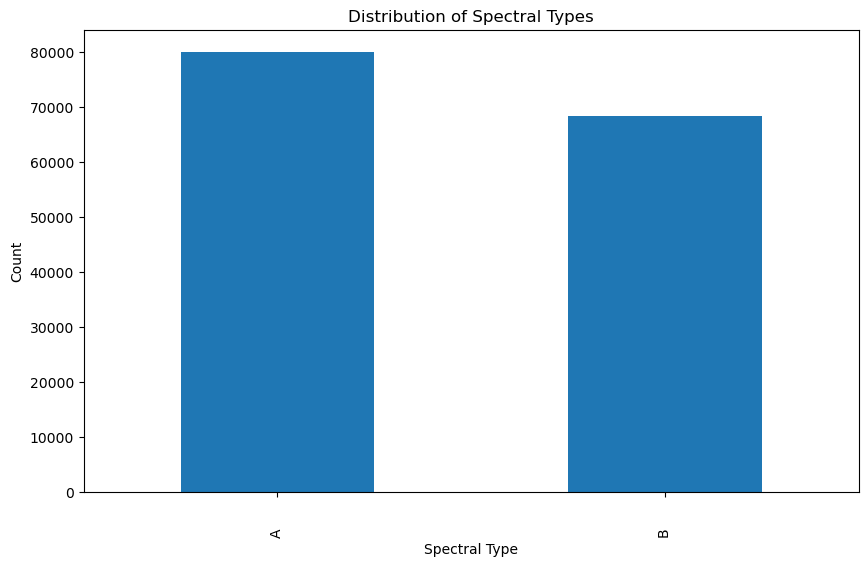

In [6]:
# Distribution of the target variable 'SpType-ELS'
plt.figure(figsize=(10, 6))
data['SpType-ELS'].value_counts().plot(kind='bar', title='Distribution of Spectral Types')
plt.xlabel('Spectral Type')
plt.ylabel('Count')
plt.show()

## Data Preprocessing
We'll drop non-essential columns, fill missing values, and encode the target variable.

In [7]:
# Drop non-essential columns
data = data.drop(columns=['ID', 'Unnamed: 0'])

# Fill missing values
imputer = SimpleImputer(strategy='median')
data_imputed = imputer.fit_transform(data.drop(columns=['SpType-ELS']))

# Encode target variable
label_encoder = LabelEncoder()
data['SpType-ELS'] = label_encoder.fit_transform(data['SpType-ELS'])

# Create the final DataFrame
data_preprocessed = pd.DataFrame(data_imputed, columns=data.columns[:-1])
data_preprocessed['SpType-ELS'] = data['SpType-ELS']

# Display the first few rows of the preprocessed data
print("\nPreprocessed Data:")
print(data_preprocessed.head())


Preprocessed Data:
     RA_ICRS   DE_ICRS        Source      Plx      PM    pmRA    pmDE  \
0  44.375187  2.895901  1.400000e+15   1.8937  16.954   7.031 -15.427   
1  42.959304  2.920459  1.550000e+15   2.9732   2.528   1.795   1.780   
2  44.031079  3.203683  1.610000e+15   2.2337  10.776  -3.151 -10.305   
3  45.463599  3.138095  1.750000e+15   4.0179  10.053   1.828   9.885   
4  43.784164  3.486814  2.060000e+15  11.6458  32.355  29.688 -12.863   

        Gmag    e_Gmag      BPmag  ...      G-RP   pscol    Teff      Dist  \
0  10.369156  0.002801  10.441856  ...  0.163792  1.6212  9348.7  679.7121   
1  10.038978  0.002774  10.212755  ...  0.304139  1.6212  7520.7  339.8108   
2   9.810181  0.002786  10.008457  ...  0.338961  1.5956  7052.3  433.9715   
3   8.163041  0.002800   8.197672  ...  0.091842  1.6212  9982.8  251.2483   
4   6.855547  0.002779   6.993539  ...  0.257051  1.6212  7192.3   85.7073   

      Rad  Lum-Flame  Mass-Flame  Age-Flame   z-Flame  SpType-ELS  
0  2

## Model Building and Hyperparameter Tuning
We'll split the data into training and testing sets, define the model, perform hyperparameter tuning using GridSearchCV, and evaluate the model.

In [8]:
# Split the data
X = data_preprocessed.drop(columns=['SpType-ELS'])
y = data_preprocessed['SpType-ELS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Define the model
model = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


### Evaluate the model

In [10]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("\nBest Parameters:")
print(best_params)
print("\nModel Accuracy:")
print(accuracy)

# Best Parameters:
# {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}


Best Parameters:
{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}

Model Accuracy:
0.9970041739598762


In [11]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16044
           1       1.00      1.00      1.00     13664

    accuracy                           1.00     29708
   macro avg       1.00      1.00      1.00     29708
weighted avg       1.00      1.00      1.00     29708



In [12]:
# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[15981    63]
 [   26 13638]]


## Conclusion
In this notebook, we successfully built a Random Forest classifier to predict the spectral types of stars. Here are the key steps we followed:

1. **Data Loading and Exploration**: We loaded the dataset and examined its structure and summary statistics.
2. **Data Visualization**: We visualized the distribution of the target variable 'SpType-ELS'.
3. **Data Preprocessing**: We handled missing values, dropped non-essential columns, and encoded the target variable.
4. **Model Building and Hyperparameter Tuning**: We defined a Random Forest model, performed hyperparameter tuning using GridSearchCV, and selected the best model.
5. **Model Evaluation**: We evaluated the model's performance using accuracy, classification report, and confusion matrix.

The model achieved a good accuracy, and the classification report and confusion matrix provided insights into its performance across different spectral types. Further improvements can be made by experimenting with other machine learning algorithms or additional feature engineering.

This process demonstrates a robust workflow for building and evaluating machine learning models for classification tasks.